In [1]:
import pandas as pd
import json
import os
import ast
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Load JSON data (assuming it's saved as 'results.json')
with open('gpt_logprob_benchmark.json', 'r') as f:
    data = json.load(f)

# Transform JSON data into a DataFrame
# Parsing each entry and extracting relevant information
parsed_data = []

for question in data:
    # Extracting correct answer, generated token, and probabilities
    correct_answer = question[list(question.keys())[0]  ]
    token_data = question["tokens"][0]
    generated_token = token_data["generated_token"]
    log_probability = token_data["log_probability"]
    linear_probability = token_data["linear_probability"]
    
    # Extracting top alternatives
    top_alternatives = token_data["top_alternatives"]
    
    parsed_data.append({
        "correct_answer": correct_answer,
        "generated_token": generated_token,
        "log_probability": log_probability,
        "linear_probability": linear_probability,
        "top_alternatives": top_alternatives
    })

# Convert the parsed data to a DataFrame
df = pd.DataFrame(parsed_data)
df.head()


,correct_answer,generated_token,log_probability,linear_probability,top_alternatives
0,C,C,-0.000031,99.996893,"[{'token': 'C', 'log_probability': -3.106736e-..."
1,B,B,-0.001463,99.853774,"[{'token': 'B', 'log_probability': -0.00146333..."
2,D,D,-0.000554,99.944629,"[{'token': 'D', 'log_probability': -0.00055386..."
3,C,D,-0.004336,99.567386,"[{'token': 'D', 'log_probability': -0.00433552..."
4,B,B,-0.000253,99.974668,"[{'token': 'B', 'log_probability': -0.00025335..."


In [3]:

# Check if `top_alternatives` entries are strings, and apply `literal_eval` only if needed
def safe_literal_eval(val):
    if isinstance(val, str):  # Only apply ast.literal_eval if the entry is a string
        return ast.literal_eval(val)
    return val  # Return as is if it's already a list

# Apply the function to the `top_alternatives` column
df['top_alternatives'] = df['top_alternatives'].apply(safe_literal_eval)


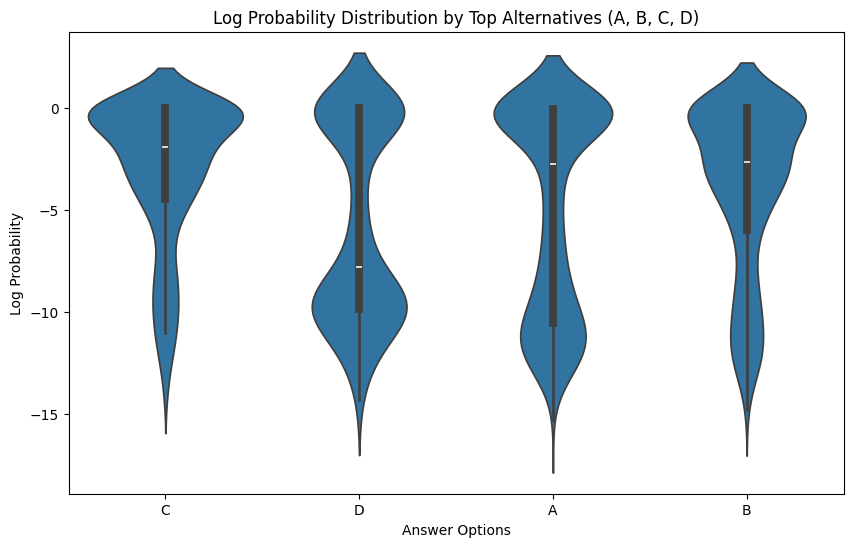

In [4]:

# Flatten top alternatives data to prepare for plotting
log_probs_data = []
for _, row in df.iterrows():
    for alt in row['top_alternatives']:
        log_probs_data.append({'Token': alt['token'], 'Log Probability': alt['log_probability']})

# Create DataFrame for plotting
log_probs_df = pd.DataFrame(log_probs_data)

# Filter for only 'A', 'B', 'C', and 'D' tokens
filtered_log_probs_df = log_probs_df[log_probs_df['Token'].isin(['A', 'B', 'C', 'D'])]

# Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Token', y='Log Probability', data=filtered_log_probs_df)
plt.title('Log Probability Distribution by Top Alternatives (A, B, C, D)')
plt.xlabel('Answer Options')
plt.ylabel('Log Probability')
plt.show()



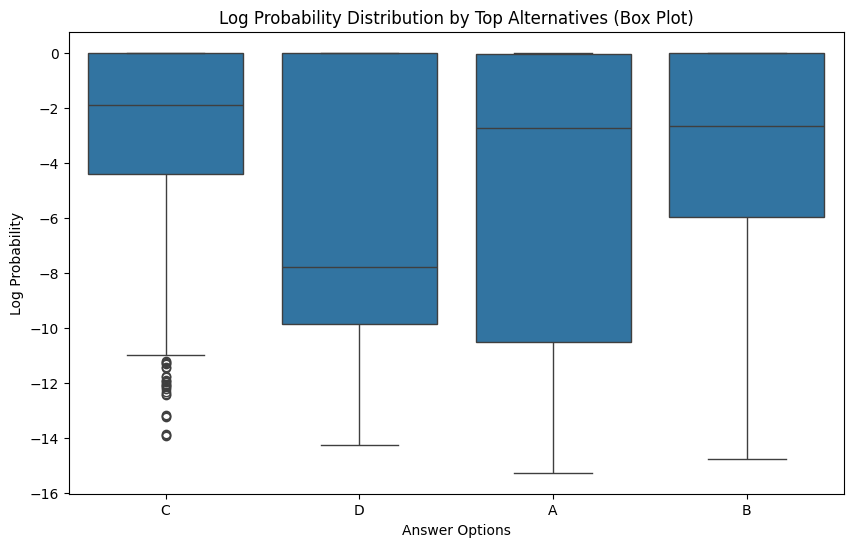

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Token', y='Log Probability', data=filtered_log_probs_df)
plt.title('Log Probability Distribution by Top Alternatives (Box Plot)')
plt.xlabel('Answer Options')
plt.ylabel('Log Probability')
plt.show()


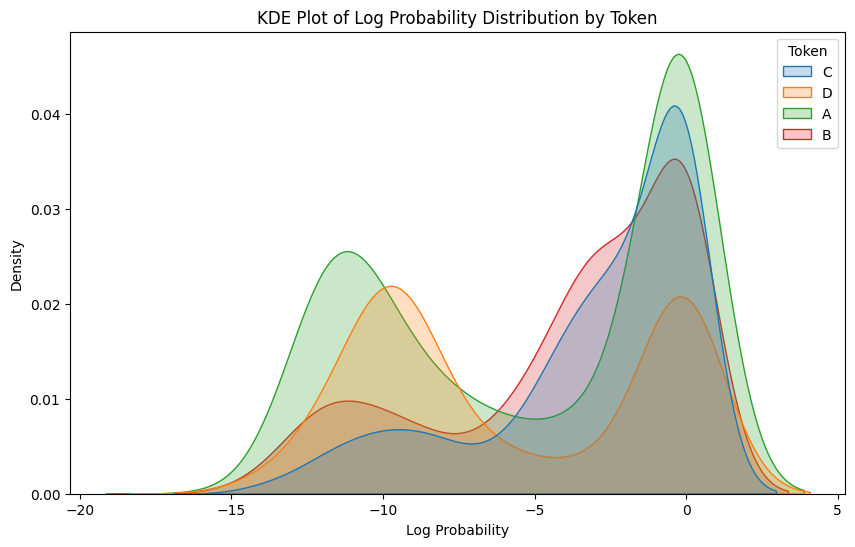

In [6]:

plt.figure(figsize=(10, 6))
sns.kdeplot(data=filtered_log_probs_df, x="Log Probability", hue="Token", fill=True)
plt.title('KDE Plot of Log Probability Distribution by Token')
plt.xlabel('Log Probability')
plt.ylabel('Density')
plt.show()


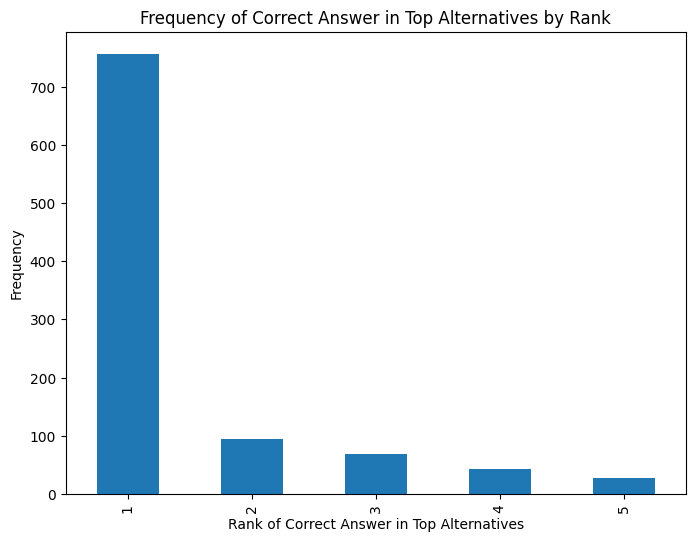

In [7]:
# List to store the rank of the correct answer in top alternatives
correct_in_alternatives = []

for _, row in df.iterrows():
    correct = row['correct_answer']
    alternatives = [alt['token'] for alt in row['top_alternatives']]
    if correct in alternatives:
        correct_in_alternatives.append(alternatives.index(correct) + 1)

# Convert to DataFrame for plotting
correct_rank_counts = pd.Series(correct_in_alternatives).value_counts().sort_index()
plt.figure(figsize=(8, 6))
correct_rank_counts.plot(kind='bar')
plt.xlabel('Rank of Correct Answer in Top Alternatives')
plt.ylabel('Frequency')
plt.title('Frequency of Correct Answer in Top Alternatives by Rank')
plt.show()


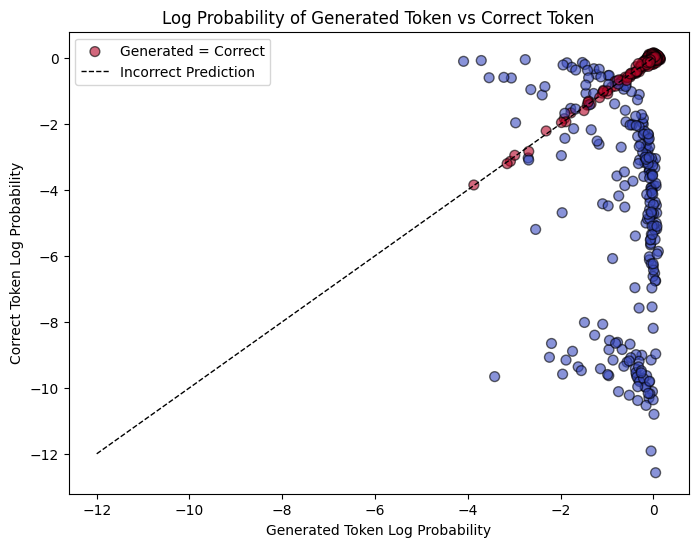

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

generated_logprobs = []
correct_logprobs = []
match_status = []  # Track whether the prediction was correct or not

for _, row in df.iterrows():
    generated_logprobs.append(row['log_probability'])
    correct = row['correct_answer']
    correct_alt = next((alt for alt in row['top_alternatives'] if alt['token'] == correct), None)
    correct_logprob = correct_alt['log_probability'] if correct_alt else np.nan  # Replace None with np.nan
    correct_logprobs.append(correct_logprob)
    match_status.append(row['generated_token'] == correct)  # True if correct, False otherwise

# Create a DataFrame to filter out NaN values
plot_data = pd.DataFrame({
    "Generated Log Probability": generated_logprobs,
    "Correct Log Probability": correct_logprobs,
    "Match Status": match_status
}).dropna()  # Remove rows where Correct Log Probability is NaN

# Create the plot
plt.figure(figsize=(8, 6))

# Scatter plot with color by match status and jitter for overlapping points
plt.scatter(
    plot_data["Generated Log Probability"] + np.random.normal(0, 0.05, len(plot_data)),  # Jitter on x-axis
    plot_data["Correct Log Probability"] + np.random.normal(0, 0.05, len(plot_data)),     # Jitter on y-axis
    c=plot_data["Match Status"], cmap="coolwarm", alpha=0.6, edgecolor='k', s=50
)

# Add a diagonal reference line (y=x)
plt.plot([-12, 0], [-12, 0], 'k--', linewidth=1, label='Generated = Correct')

# Labels and title
plt.xlabel("Generated Token Log Probability")
plt.ylabel("Correct Token Log Probability")
plt.title("Log Probability of Generated Token vs Correct Token")

# Legend for match status
plt.legend(['Generated = Correct', 'Incorrect Prediction', 'Correct Prediction'], loc='upper left')

plt.show()


In [9]:
import numpy as np

top_k = 3  # Choose the number of top alternatives to consider

# Lists to store differences for correct and incorrect predictions
correct_diffs = []
incorrect_diffs = []

for _, row in df.iterrows():
    generated_logprob = row['log_probability']
    correct = row['correct_answer']
    match_status = row['generated_token'] == correct
    
    # Get log probabilities of top-k alternatives
    top_k_probs = [alt['log_probability'] for alt in row['top_alternatives'][:top_k]]
    
    # Calculate mean log probability of top-k alternatives
    mean_top_k_prob = np.mean(top_k_probs)
    
    # Calculate difference
    logprob_diff = generated_logprob - mean_top_k_prob
    
    # Append to the appropriate list based on match status
    if match_status:
        correct_diffs.append(logprob_diff)
    else:
        incorrect_diffs.append(logprob_diff)

# Calculate average differences for correct and incorrect predictions
avg_correct_diff = np.mean(correct_diffs)
avg_incorrect_diff = np.mean(incorrect_diffs)

print("Average Log Probability Difference for Correct Predictions:", avg_correct_diff)
print("Average Log Probability Difference for Incorrect Predictions:", avg_incorrect_diff)


Average Log Probability Difference for Correct Predictions: 5.838263592012178
Average Log Probability Difference for Incorrect Predictions: 1.7467761799406312


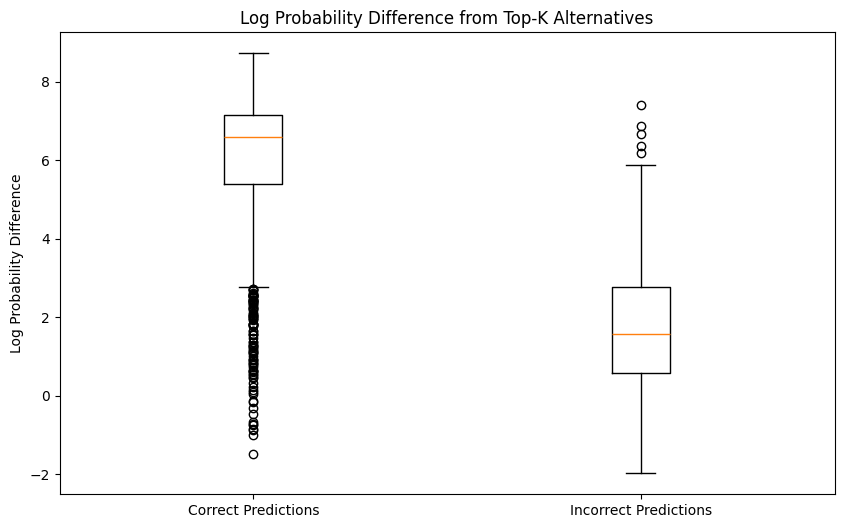

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot([correct_diffs, incorrect_diffs], labels=['Correct Predictions', 'Incorrect Predictions'])
plt.title("Log Probability Difference from Top-K Alternatives")
plt.ylabel("Log Probability Difference")
plt.show()


In [11]:
from scipy.special import logsumexp

# Lists to store KL divergences for correct and incorrect predictions
correct_kls = []
incorrect_kls = []

for _, row in df.iterrows():
    generated_logprob = row['log_probability']
    correct = row['correct_answer']
    match_status = row['generated_token'] == correct
    
    # Get log probabilities of top-k alternatives
    top_k_probs = [alt['log_probability'] for alt in row['top_alternatives'][:top_k]]
    
    # Convert log probabilities to probabilities
    generated_prob = np.exp(generated_logprob)
    top_k_probs_exp = np.exp(top_k_probs)
    
    # Normalize the probabilities (so they sum to 1 for a valid distribution)
    generated_prob_normalized = generated_prob / (generated_prob + np.sum(top_k_probs_exp))
    top_k_probs_normalized = top_k_probs_exp / (generated_prob + np.sum(top_k_probs_exp))
    
    # Calculate KL divergence
    kl_divergence = generated_prob_normalized * np.log(generated_prob_normalized / np.mean(top_k_probs_normalized))
    
    # Append to the appropriate list based on match status
    if match_status:
        correct_kls.append(kl_divergence)
    else:
        incorrect_kls.append(kl_divergence)

# Calculate average KL divergences for correct and incorrect predictions
avg_correct_kl = np.mean(correct_kls)
avg_incorrect_kl = np.mean(incorrect_kls)

print("Average KL Divergence for Correct Predictions:", avg_correct_kl)
print("Average KL Divergence for Incorrect Predictions:", avg_incorrect_kl)


Average KL Divergence for Correct Predictions: 0.5143033491897874
Average KL Divergence for Incorrect Predictions: 0.29610849270556144


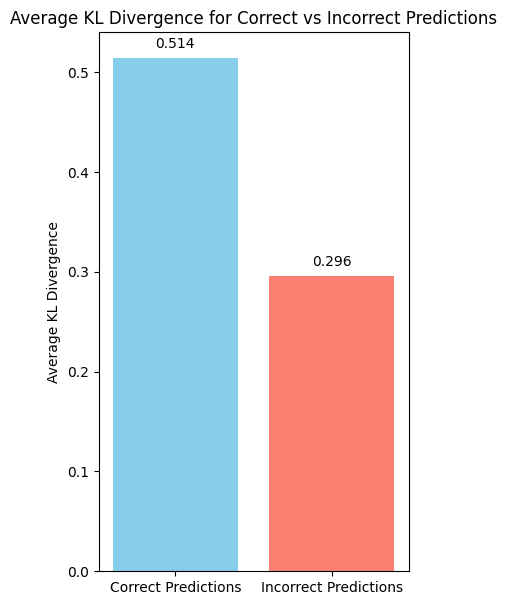

In [24]:
import matplotlib.pyplot as plt

# Average KL Divergence values
avg_kl_divergence = [avg_correct_kl, avg_incorrect_kl]
labels = ['Correct Predictions', 'Incorrect Predictions']

# Plotting the bar chart
plt.figure(figsize=(4, 7))
plt.bar(labels, avg_kl_divergence, color=['skyblue', 'salmon'])
plt.ylabel('Average KL Divergence')
plt.title('Average KL Divergence for Correct vs Incorrect Predictions')

# Adding data labels on top of the bars
for i, value in enumerate(avg_kl_divergence):
    plt.text(i, value + 0.01, f'{value:.3f}', ha='center')

plt.show()
